In [85]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""SELECT brand_title, price_numeric, status, catalog_id, size_title, color1_id
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               """
data = pd.read_sql(sql_query, engine)
data

,brand_title,price_numeric,status,catalog_id,size_title,color1_id
0,Oakley,65.0,Muito bom,98.0,,1.0
1,Oakley,65.0,Muito bom,98.0,,1.0
2,Oakley,70.0,Muito bom,98.0,,3.0
3,Oakley,70.0,Novo sem etiquetas,98.0,,1.0
4,Oakley,65.0,Muito bom,98.0,,1.0
...,...,...,...,...,...,...
452435,Oakley,65.0,Novo sem etiquetas,98.0,,1.0
452436,Oakley,70.0,Novo sem etiquetas,98.0,,1.0
452437,Oakley,70.0,Novo sem etiquetas,98.0,,9.0
452438,Oakley,70.0,Muito bom,98.0,,2.0


In [86]:
data2 = data[data["catalog_id"] == data["catalog_id"].value_counts().idxmax()]
data2 = data2.groupby(["brand_title"])["price_numeric"].agg(["count", "std", "median", "sum"])
data2 = data2[data2["count"] > 50]
data2 = data2.reset_index()
data2

,brand_title,count,std,median,sum
0,,1352,5.319588,4.0,6208.0
1,Bershka,215,4.204111,4.0,1047.0
2,Bizzbee,58,1.786553,2.0,176.0
3,Cache Cache,209,1.972354,3.0,770.0
4,Calvin Klein,70,3.550756,9.0,758.0
5,Camaïeu,354,0.894957,3.0,1096.0
6,Champion,59,1.476882,8.0,395.0
7,Costes,62,2.303057,4.0,268.0
8,Desigual,51,2.868080,12.0,606.0
9,Elisabetta Franchi,66,10.485021,49.0,3222.0


In [99]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

# Create subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=("Median vs Count", "Median vs Standard Dev.", "Median vs Total Volume"))

# Add scatterplot for median vs count
scatter1 = go.Scatter(x=data2['median'], y=data2['count'], mode='markers+text', text=data2['brand_title'], name='Median vs Count', customdata=np.stack((data2['brand_title'], data2['std'], data2['sum'], data2['count']), axis = 1))
fig.add_trace(scatter1, row=1, col=1)
fig.update_traces(
    hovertemplate="Brand: %{customdata[0]}<br>Median: %{x:,.1f} <br>Count: %{customdata[3]:,.0f}<br>Volume: %{customdata[2]:,.0f}<br>Std Dev: %{customdata[1]:,.0f}",
    
)

# Add scatterplot for median vs standard deviation
scatter2 = go.Scatter(x=data2['median'], y=data2['std'], mode='markers', name='Median vs Standard Dev.', customdata=np.stack((data2['brand_title'], data2['std'], data2['sum'], data2['count']), axis = 1))
fig.add_trace(scatter2, row=1, col=2)
fig.update_traces(
    hovertemplate="Brand: %{customdata[0]}<br>Median: %{x:,.1f} <br>Count: %{y:,.0f}<br>Volume: %{customdata[2]:,.0f}<br>Std Dev: %{customdata[1]:,.0f}",
    
)

# Add scatterplot for median vs total volume
scatter3 = go.Scatter(x=data2['median'], y=data2['sum'], mode='markers', name='Median vs Total Volume', customdata=np.stack((data2['brand_title'], data2['std'], data2['sum'], data2['count']), axis = 1))
fig.add_trace(scatter3, row=1, col=3)
fig.update_traces(
    hovertemplate="Brand: %{customdata[0]}<br>Median: %{x:,.1f} <br>Count: %{y:,.0f}<br>Volume: %{customdata[2]:,.0f}<br>Std Dev: %{customdata[1]:,.0f}",
    
)

# Update layout
fig.update_layout(title='Scatterplots of Median vs Various Metrics', showlegend=False, height=500, width=1000)


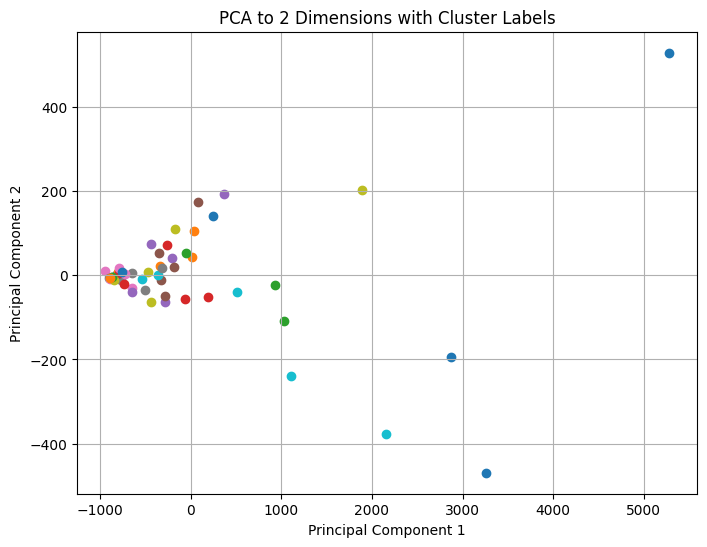

In [101]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(data2.drop("brand_title", axis = 1))

# Assign cluster labels to the transformed data
data_with_labels = pd.DataFrame(X_2d, index=data2.index, columns=['PC1', 'PC2'])

# Plot the transformed data with colors based on cluster labels
plt.figure(figsize=(8, 6))
for cluster_label in data_with_labels.index:
    plt.scatter(data_with_labels.loc[data_with_labels.index == cluster_label, 'PC1'],
                data_with_labels.loc[data_with_labels.index == cluster_label, 'PC2'],
                label=f'Cluster {cluster_label}')
plt.title('PCA to 2 Dimensions with Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

In [109]:
from sklearn.svm import OneClassSVM

# Prepare the data
X = data2[['median', 'count', 'std', 'sum']].values

# Fit the One-Class SVM model
svm_model = OneClassSVM(kernel='rbf', nu=0.1)  # Adjust parameters as needed
svm_model.fit(X)

# Predict the labels
labels = svm_model.predict(X)

# Define the range of values for 'median' and 'count'
median_range = np.linspace(data2['median'].min(), data2['median'].max(), 100)
count_range = np.linspace(data2['count'].min(), data2['count'].max(), 100)
std_range = np.linspace(data2['std'].min(), data2['std'].max(), 100)
sum_range = np.linspace(data2['sum'].min(), data2['sum'].max(), 100)

median_grid, count_grid = np.meshgrid(median_range, count_range)
X_grid = np.column_stack((median_grid.ravel(), count_grid.ravel()))

# Compute decision function values for each point in the grid
decision_values = svm_model.decision_function(X_grid)
decision_values_grid = decision_values.reshape(median_grid.shape)

# Plot the contour plot with decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(median_grid, count_grid, decision_values_grid, levels=np.linspace(decision_values.min(), 0, 10), cmap=plt.cm.PuBu)
plt.colorbar(label='Decision Function Value')
plt.scatter(data2['median'], data2['count'], c=labels, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Median')
plt.ylabel('Count')
plt.title('One-Class SVM Decision Boundary')
plt.grid(True)

ValueError: X has 2 features, but OneClassSVM is expecting 4 features as input.